# Analyze and plot experiment results

This notebook illustrates how to analyze and plot results obtained with SageMaker Bencher.

As an example, we will replicate benchmark analysis and re-create plots presented in the blog post *["Choose the best data source for your Amazon SageMaker training job"](https://aws.amazon.com/blogs/machine-learning/choose-the-best-data-source-for-your-amazon-sagemaker-training-job/) (G. Nachum, A. Arzhanov)*. To this end, it is assumed that we have first ourselves reproduced the benchmarks presented in the mentioned blog post with the SageMaker Bencher by running:

`python start_experiment.py -f experiments/blog-benchmarks-all.yml`

Once all the trials of the `blog-benchmark-all` experiment have finished, we can proceed with this notebook to analyse and plot the results.

----

## Import all required packages
We will use `sagemaker.analytics` package to fetch all trial component data stored in SageMaker Experiments and convert it into a Pandas DataFrame for detailed analisys. For more information see *["Amazon SageMaker Experiments - Organize, Track, and Compare Your Machine Learning Trainings"](https://aws.amazon.com/blogs/aws/amazon-sagemaker-experiments-organize-track-and-compare-your-machine-learning-trainings/)*.

In [1]:
from sagemaker.analytics import ExperimentAnalytics

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [2]:
experiment_name = 'blog-benchmarks-all'
analytics = ExperimentAnalytics(experiment_name=experiment_name)    
df = analytics.dataframe()
df.describe()

,SageMaker.InstanceCount,SageMaker.VolumeSizeInGB,batch_size,epochs,img_sec_ave_tot,img_tot,input_dim,instance_count,max_run,num_parallel_calls,...,t_downloading,t_epoch_1,t_import_framework,t_starting,t_training,t_training_exact,t_training_sm,t_uploading,volume_size,SageMaker.ModelArtifact - MediaType
count,37.0,37.0,37.0,37.0,36.000000,3.600000e+01,37.0,36.0,36.0,37.0,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.0,0.0
mean,1.0,500.0,64.0,1.0,277.114662,7.804785e+05,224.0,1.0,36000.0,-1.0,...,988.231500,2779.954310,0.000002,116.300167,2972.268194,2780.133761,3966.000000,5.447306,500.0,NaN
std,0.0,0.0,0.0,0.0,56.452787,7.605085e+05,0.0,0.0,0.0,0.0,...,3050.065027,2959.798800,0.000001,15.139378,3001.777274,2959.823517,4660.215887,0.091283,0.0,NaN
min,1.0,500.0,64.0,1.0,156.142469,3.060700e+04,224.0,1.0,36000.0,-1.0,...,6.774000,111.297508,0.000000,99.926000,151.251000,111.408272,309.000000,5.307000,500.0,NaN
25%,1.0,500.0,64.0,1.0,268.677873,3.060700e+04,224.0,1.0,36000.0,-1.0,...,14.151250,113.122569,0.000002,107.121250,305.722000,113.304401,333.000000,5.394750,500.0,NaN
50%,1.0,500.0,64.0,1.0,273.414449,7.804785e+05,224.0,1.0,36000.0,-1.0,...,20.420000,2410.863770,0.000002,111.388500,2546.336500,2411.098773,2647.000000,5.422000,500.0,NaN
75%,1.0,500.0,64.0,1.0,326.925934,1.530350e+06,224.0,1.0,36000.0,-1.0,...,192.413250,4680.089649,0.000002,118.718000,4886.386500,4680.254941,5069.500000,5.490000,500.0,NaN
max,1.0,500.0,64.0,1.0,330.192943,1.530350e+06,224.0,1.0,36000.0,-1.0,...,11166.507000,9800.736901,0.000007,167.431000,10150.562000,9800.985027,15878.000000,5.716000,500.0,NaN


## Some pre-processing
While we track a lot of various parameters and metrics in each trial (see above), for this analysis we would need only a couple of them. For example, we will only focus on the following trial parameters:
- `img_sec_ave_tot` - an average throughput of the training job in terms of *images/sec*,
- `dataset/train` - name of the dataset used in the *train* input channel,
- `input_format/train` - file format (e.g., JPG-files, or TFRecord-files) of the dataset used in *train* input channel,
- `input_mode/train` - data input mode used for the *train* input channel (e.g., File, FastFile, or FSx),
- `t_*`-metrics - the exact timing for different phases of the training job (e.g. download, train, or total billable time),
- `img_tot` - the total number of processed images by the training job.

In [3]:
col_focus = [
    'TrialComponentName',
    'img_sec_ave_tot',
    'dataset/train',
    'input_format/train',
    'input_mode/train',
    't_downloading',
    't_training',
    't_training_exact',
    't_training_sm',
    'instance_type',
    'img_tot'
]

dataset_map = {
    'Caltech-jpg-1x': 'Smaller Dataset / Smaller Files',
    'Caltech-tfr-jpg-1x': 'Smaller Dataset / Larger Files',
    'Caltech-jpg-50x': 'Larger Dataset / Smaller Files',
    'Caltech-tfr-jpg-50x': 'Larger Dataset / Larger Files',
}

df = df[col_focus]
df = df.dropna()
df['dataset_spec/train'] = df['dataset/train'].map(dataset_map)
df.sort_values(by='input_mode/train', inplace=True, ascending=False)
df.shape

(36, 12)

## Tabular statistics
We can slice and dice the extracted Pandas DataFrame as we see fit. For example, we can make sure that we have indeed repeated each trial 3 times to account for any variance in the timings.

In [4]:
df_grouped = df.groupby(['input_format/train', 'dataset/train', 'input_mode/train']).count()
df_grouped

TrialComponentName  \
input_format/train dataset/train       input_mode/train                       
jpg                Caltech-jpg-1x      ffm                                3   
                                       file                               3   
                                       fsx                                3   
                   Caltech-jpg-50x     ffm                                3   
                                       file                               3   
                                       fsx                                3   
tfrecord/jpg       Caltech-tfr-jpg-1x  ffm                                3   
                                       file                               3   
                                       fsx                                3   
                   Caltech-tfr-jpg-50x ffm                                3   
                                       file                               3   
                                       fsx                                3   

                                                         img_sec_ave_tot  \
input_format/train dataset/train       input_mode/train                    
jpg                Caltech-jpg-1x      ffm                             3   
                                       file                            3   
                                       fsx                             3   
                   Caltech-jpg-50x     ffm                             3   
                                       file                            3   
                                       fsx                             3   
tfrecord/jpg       Caltech-tfr-jpg-1x  ffm                             3   
                                       file                            3   
                                       fsx                             3   
                   Caltech-tfr-jpg-50x ffm                             3   
                                       file                            3   
                                       fsx                             3   

                                                         t_downloading  \
input_format/train dataset/train       input_mode/train                  
jpg                Caltech-jpg-1x      ffm                           3   
                                       file                          3   
                                       fsx                           3   
                   Caltech-jpg-50x     ffm                           3   
                                       file                          3   
                                       fsx                           3   
tfrecord/jpg       Caltech-tfr-jpg-1x  ffm                           3   
                                       file                          3   
                                       fsx                           3   
                   Caltech-tfr-jpg-50x ffm                           3   
                                       file                          3   
                                       fsx                           3   

                                                         t_training  \
input_format/train dataset/train       input_mode/train               
jpg                Caltech-jpg-1x      ffm                        3   
                                       file                       3   
                                       fsx                        3   
                   Caltech-jpg-50x     ffm                        3   
                                       file                       3   
                                       fsx                        3   
tfrecord/jpg       Caltech-tfr-jpg-1x  ffm                        3   
                                       file                       3   
                                       fsx                        3   
                   Caltech-tfr-jpg-50x ffm                        3

After this, we can also print out the average values for every unique trial scenario.

In [5]:
df_grouped = df.groupby(['input_format/train', 'dataset/train', 'input_mode/train']).mean()
df_grouped

img_sec_ave_tot  \
input_format/train dataset/train       input_mode/train                    
jpg                Caltech-jpg-1x      ffm                    168.419023   
                                       file                   268.861786   
                                       fsx                    273.752569   
                   Caltech-jpg-50x     ffm                    165.830324   
                                       file                   329.453352   
                                       fsx                    328.379459   
tfrecord/jpg       Caltech-tfr-jpg-1x  ffm                    271.146103   
                                       file                   270.676306   
                                       fsx                    269.522753   
                   Caltech-tfr-jpg-50x ffm                    325.788708   
                                       file                   327.262672   
                                       fsx                    326.282893   

                                                         t_downloading  \
input_format/train dataset/train       input_mode/train                  
jpg                Caltech-jpg-1x      ffm                   18.845333   
                                       file                 255.186333   
                                       fsx                   10.397000   
                   Caltech-jpg-50x     ffm                  169.415000   
                                       file               10954.684000   
                                       fsx                   12.094333   
tfrecord/jpg       Caltech-tfr-jpg-1x  ffm                   15.862000   
                                       file                  22.123333   
                                       fsx                   13.735000   
                   Caltech-tfr-jpg-50x ffm                   17.082333   
                                       file                 357.262333   
                                       fsx                   12.091000   

                                                          t_training  \
input_format/train dataset/train       input_mode/train                
jpg                Caltech-jpg-1x      ffm                388.769333   
                                       file               154.636667   
                                       fsx                322.110333   
                   Caltech-jpg-50x     ffm               9598.554333   
                                       file              4703.002000   
                                       fsx               5099.711667   
tfrecord/jpg       Caltech-tfr-jpg-1x  ffm                293.759333   
                                       file               300.330000   
                                       fsx                303.629000   
                   Caltech-tfr-jpg-50x ffm               4884.751667   
                                       file              4723.395667   
                                       fsx               4894.568333   

                                                         t_training_exact  \
input_format/train dataset/train       input_mode/train                     
jpg                Caltech-jpg-1x      ffm                     181.852903   
                                       file                    113.843675   
                                       fsx                     111.805900   
                   Caltech-jpg-50x     ffm                    9245.096518   
                                       file                   4645.132867   
                                       fsx                    4660.390200   
tfrecord/jpg       Caltech-tfr-jpg-1x  ffm                     112.882378   
                                       file                    113.099438   
                                       fsx                     113.571342   
                   Caltech-tfr-jpg-50x ffm                    4697.403220   
                      

## Visualize the results
We can now produce all kinds of plots to visualize and analise the benchmark results. For example let us first plot the average **throughput** (images/sec) for different datasets, and then plot the **total billable time** (sec) for each of these SageMaker training jobs.

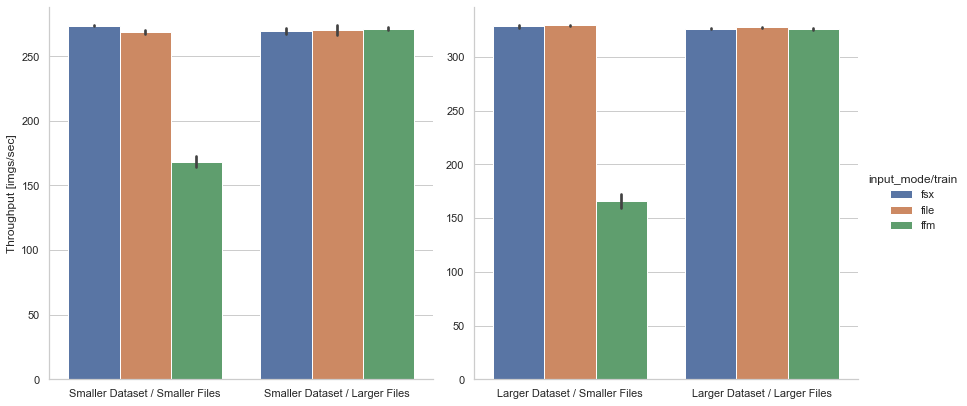

In [6]:
g = sns.catplot(data=df, x='dataset_spec/train', y='img_sec_ave_tot',
                hue='input_mode/train', col='img_tot', ci='sd',
                kind='bar', sharey=False, sharex=False, height=6)
g.set_axis_labels('', 'Throughput [imgs/sec]').set_titles("")

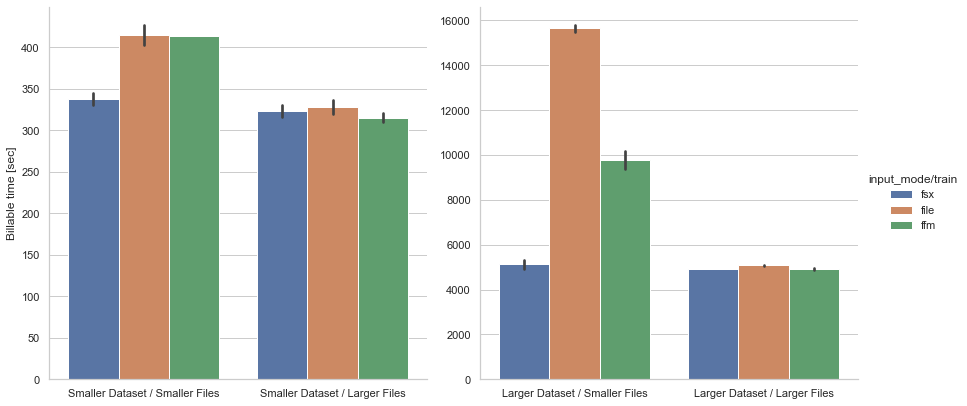

In [7]:
g = sns.catplot(data=df, x='dataset_spec/train', y='t_training_sm',
                hue='input_mode/train', col='img_tot', ci='sd',
                kind='bar', sharey=False, sharex=False, height=6)
g.set_axis_labels('', 'Billable time [sec]').set_titles("")

# Replicate plots from the blog post
Now let us try to replicate the benchmark plots from the blog post, which show the total job time with the breakdown for the downloading, training, and other stages. See *["Choose the best data source for your Amazon SageMaker training job"](https://aws.amazon.com/blogs/machine-learning/choose-the-best-data-source-for-your-amazon-sagemaker-training-job/)* for details.

### Some helper function for fancy plotting

In [8]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def plot_stacked_times(df, title=None, lim=None, savefile=None, bar_width=0.5, **kw):
    
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    sns.set_palette("deep")
    
    x_col = 'input_mode/train'
    
    clrs = {
        'train': 'coral',
        'download': 'cornflowerblue',
        'rest': 'grey'
    }
    
    _df = df.copy()
    
    _df['t_dnt'] = _df['t_training_exact'] + _df['t_downloading']
    
    fig, ax = plt.subplots()

    bar_tot = sns.barplot(x=x_col,  y="t_training_sm", data=_df, color=clrs['rest'], ax=ax, **kw)
    bar_dnt = sns.barplot(x=x_col,  y="t_dnt", data=_df, color=clrs['download'], ax=ax, **kw)
    bar_exact = sns.barplot(x=x_col,  y="t_training_exact", data=_df, color=clrs['train'], ax=ax, **kw)
    
    if lim:
        bar_tot.set_ylim(lim)
        bar_dnt.set_ylim(lim)
        bar_exact.set_ylim(lim)

    top_bar = mpatches.Patch(color=clrs['rest'], label='setup time')
    mid_bar = mpatches.Patch(color=clrs['train'], label='training time')
    bottom_bar = mpatches.Patch(color=clrs['download'], label='downloading time')
    
    #change width
    change_width(ax, bar_width)
    
    #add text
    #show_values_on_bars(ax)

    #plt.legend(handles=[mid_bar, bottom_bar], loc='upper left')
    
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ticklabels = ['FSx', 'File', 'FastFile']
    ax.set_xticklabels(ticklabels)
    
    ax.set_xlabel('Input Mode', fontsize=18, fontweight='bold')
    ax.set_ylabel('Job Time [s]', fontsize=18, fontweight='bold')
    
    fig.set_size_inches(8, 6)
    
    if title:
        plt.title(title, fontdict = {'fontsize' : 20})

    # show the graph
    plt.show()
    
    if savefile:
        fig.savefig(savefile, bbox_inches='tight')

### Blog post plots

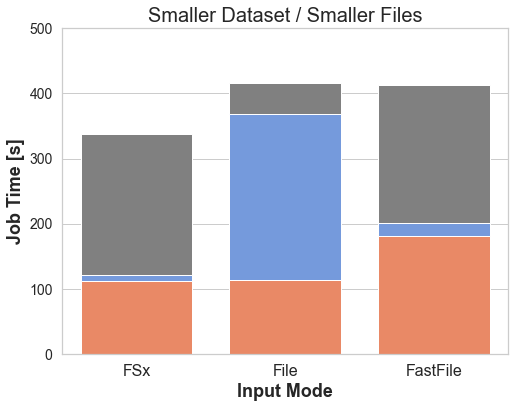

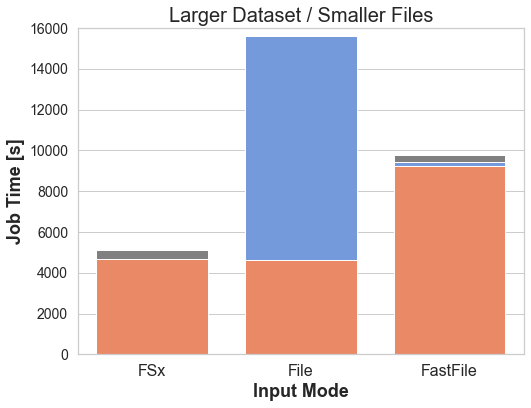

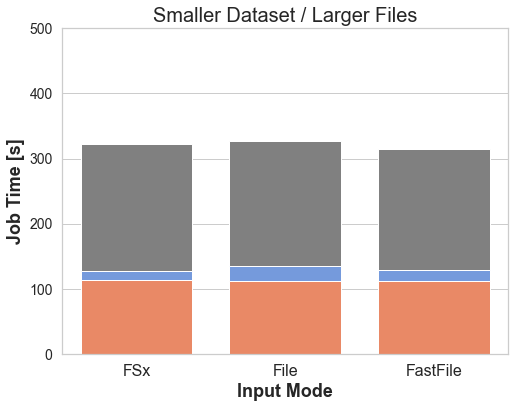

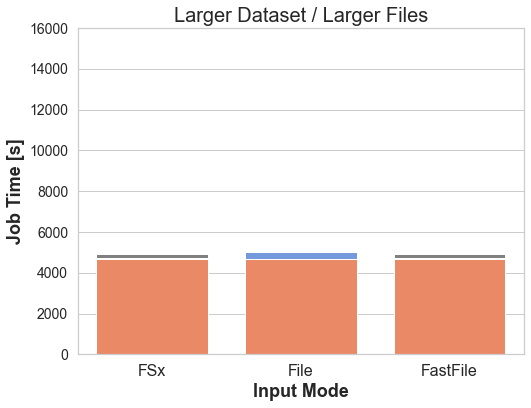

In [9]:
plot_params = [
    ('Smaller Dataset / Smaller Files', 500),
    ('Larger Dataset / Smaller Files', 16000),
    ('Smaller Dataset / Larger Files', 500),
    ('Larger Dataset / Larger Files', 16000),
]

for ds, ylim in plot_params:
    df_to_plot = df.loc[df['dataset_spec/train'] == ds]
    plot_stacked_times(df_to_plot, title=ds, lim=[0, ylim], ci=None, dodge=False, bar_width=0.75)

**Do your results look similar to the ones from the blog post?**
![Blog Results](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/02/15/ML-2979-image005.jpg)

Source: *["Choose the best data source for your Amazon SageMaker training job"](https://aws.amazon.com/blogs/machine-learning/choose-the-best-data-source-for-your-amazon-sagemaker-training-job/) (G. Nachum, A. Arzhanov)*